<a href="https://colab.research.google.com/github/JNPauli/Emotional_Machines/blob/main/Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import X and y

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
os.chdir('/content/drive/MyDrive/Thesis')

In [5]:
y = np.load('train_con.npy')

In [6]:
y_ = y[0:10000]
y_frames = y[14276:]

In [7]:
y_all = np.concatenate((y_,y_frames))

In [8]:
unique, counts = np.unique(y_all,return_counts=True)

In [9]:
counts

array([  184,  1620,  3009,  6252,  7186, 12221, 11000,  6024,  3153,
        1395])

NEW APPROACH:

Fit CNN on X

1. Read `n-rows`from X.

In [10]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [11]:
X = np.load('X_npy.npy')

In [12]:
X_train_,X_test_,y_train_,y_test_ = train_test_split(X,y_,test_size=0.2,random_state=42)

In [13]:
del X,y_
gc.collect()

11

In [14]:
X_frames = np.load('frames_npy.npy')

In [15]:
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_frames,y_frames,test_size=0.2,random_state=42)

In [16]:
del X_frames,y_frames
gc.collect()

11

Converting X to appropriate Datatype...

In [17]:
X_tensor_train = torch.from_numpy(X_train_)
del X_train_
gc.collect()
X_tensor_test = torch.from_numpy(X_test_)
del X_test_
gc.collect()

y_tensor_train = torch.from_numpy(y_train_)
del y_train_
gc.collect()
y_tensor_test = torch.from_numpy(y_test_)
del y_test_
gc.collect()


0

In [18]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)


y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)


<ipython-input-18-224f70498d00>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
<ipython-input-18-224f70498d00>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)


In [19]:
X_tensor_train_ = torch.from_numpy(X_train_f)
del X_train_f
gc.collect()
X_tensor_test_ = torch.from_numpy(X_test_f)
del X_test_f
gc.collect()



y_tensor_train_ = torch.from_numpy(y_train_f)
del y_train_f
gc.collect()
y_tensor_test_ = torch.from_numpy(y_test_f)
del y_test_f
gc.collect()


0

In [20]:
X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)


y_tensor_train_ = y_tensor_train_.type(torch.LongTensor)
y_tensor_test_ = y_tensor_test_.type(torch.LongTensor)


<ipython-input-20-c8804b6c7935>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
<ipython-input-20-c8804b6c7935>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)


In [21]:
X_tensor_train = torch.cat((X_tensor_train,X_tensor_train_),0)
X_tensor_test = torch.cat((X_tensor_test,X_tensor_test_),0)


y_tensor_train = torch.cat((y_tensor_train,y_tensor_train_),0)
y_tensor_test = torch.cat((y_tensor_test,y_tensor_test_),0)


In [22]:
X_tensor_train = X_tensor_train.expand(-1, 3, -1, -1)
X_tensor_test = X_tensor_test.expand(-1, 3, -1, -1)


In [23]:
print('training shape X is {}, , test shape X is{}'.format(X_tensor_train.shape,X_tensor_test.shape))

training shape X is torch.Size([13878, 3, 224, 224]), , test shape X istorch.Size([3470, 3, 224, 224])


To get max value of classN-1

In [24]:
y_tensor_train = y_tensor_train-1
y_tensor_test = y_tensor_test-1


Setup custom dataset class

In [25]:
train_mean = ([0.0026, 0.0026, 0.0026])
train_std = ([1.0007, 1.0007, 1.0007])

In [26]:
test_mean = ([0.0510, 0.0510, 0.0510])
test_std = ([0.0520, 0.0520, 0.0520])

In [27]:
val_mean = ([0.0512, 0.0512, 0.0512])
val_std = ([0.0518, 0.0518, 0.0518])

In [28]:
class TrainDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize(train_mean, train_std)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [29]:
class TestDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize(train_mean, train_std)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [30]:
class ValDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize(train_mean, train_std)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [31]:
dataset_train = TrainDataset(X_tensor_train,y_tensor_train,transform=True)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = TestDataset(X_tensor_test,y_tensor_test,transform=True)
dataloader_test = DataLoader(dataset_test, batch_size = 64,shuffle=False)


In [32]:
#mean = 0.
#std = 0.
#for images, _ in dataloader_train:
 #   batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
  #  images = images.view(batch_samples, images.size(1), -1)
   # mean += images.mean(2).sum(0)
    #std += images.std(2).sum(0)

#mean /= len(dataloader_train.dataset)
#std /= len(dataloader_train.dataset)

Setting up the CNN.

In [33]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.batch = nn.BatchNorm2d(32)
        #self.conv2 = nn.Conv2d(32,64,3) #remove layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(394272, 128)
        #self.fc2 = nn.Linear(128,10)
        self.Arousal = nn.Linear(128,10) #3
        self.Valence = nn.Linear(128,10)
        self.Dominance = nn.Linear(128,10)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch(x)
        x = F.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        #x = self.fc2(x)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance
#removed

In [34]:
SalienceNet = CNN()
#SalienceNet.to(device)

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


In [37]:
from torcheval.metrics.functional import multiclass_f1_score

In [38]:
F1 = multiclass_f1_score

In [39]:
from tqdm import tqdm
def train(net, loss_fn, dataloader_train,dataloader_test,
          epoch=10, learning_rate=0.0001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4)#torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    for param in model_CNN.parameters():
        param.requires_grad = False
    for param in model_CNN.Arousal.parameters():
      param.requires_grad = True
    for param in model_CNN.Valence.parameters():
      param.requires_grad = True
    for param in model_CNN.Dominance.parameters():
      param.requires_grad = True


    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    prediction_train=[]
    target_train=[]

    train_predictions_ar = []
    train_targets_ar = []
    train_predictions_val = []
    train_targets_val = []
    train_predictions_do = []
    train_targets_do = []

    test_predictions_ar = []
    test_targets_ar = []
    test_predictions_val = []
    test_targets_val = []
    test_predictions_do = []
    test_targets_do = []

    f1_accuracy_train=[]
    f1_accuracy_val=[]

    train_epoch_loss = []
    val_epoch_loss = []

    net.to(device)
    net.train()
    for i in range(epoch):
        train_loop = tqdm(dataloader_train)

        total = 0
        correct_a,correct_v,correct_d=0,0,0
        correct_a_f1,correct_v_f1,correct_d_f1=0,0,0
        val_a_f1,val_v_f1,val_d_f1=0,0,0


        for data, label in train_loop:
            data, label = data.to(device), label.to(device)
            #make prediction
            Arousal,Valence,Dominance = net(data.float())

            _a, y_pred_train_arousal = torch.max(Arousal,1)
            _v, y_pred_train_valence = torch.max(Valence,1)
            _d, y_pred_train_dominance = torch.max(Dominance,1)

            train_predictions_ar.append(y_pred_train_arousal)
            train_predictions_val.append(y_pred_train_valence)
            train_predictions_do.append(y_pred_train_dominance)

            train_targets_ar.append(label[:,0])
            train_targets_val.append(label[:,1])
            train_targets_do.append(label[:,2])

            total += label[:,0].size(0)+label[:,1].size(0)+label[:,2].size(0)

            correct_a += (y_pred_train_arousal == label[:,0]).sum().item()
            correct_v += (y_pred_train_valence == label[:,1]).sum().item()
            correct_d += (y_pred_train_dominance == label[:,2]).sum().item()

            correct_a_f1 += F1(y_pred_train_arousal, label[:,0],average='weighted',num_classes=10)
            correct_v_f1 += F1(y_pred_train_valence, label[:,1],average='weighted',num_classes=10)
            correct_d_f1 += F1(y_pred_train_dominance, label[:,2],average='weighted',num_classes=10)

            sum_f1 = ((correct_a_f1/len(dataloader_train))+(correct_d_f1/len(dataloader_train))+(correct_v_f1/len(dataloader_train)))

            sum_correct = (correct_a+correct_v+correct_d)
            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            #loss = loss_fn(output,label)#torch.max(label.long(), 1)[0])
            loss_arousal = loss_fn(Arousal,label[:,0])
            loss_valence = loss_fn(Valence,label[:,1])
            loss_dominance = loss_fn(Dominance,label[:,2])
            loss=loss_arousal+loss_valence+loss_dominance


            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient update

            train_loss.append(loss.item())
            train_loop.set_description(f"Epoch [{i+1}/{epoch}]")

        train_accuracy.append(sum_correct/total)
        f1_accuracy_train.append(sum_f1)
        train_epoch_loss.append((np.array(train_loss).mean()))

         #validation
        net.eval()
        val_total = 0
        val_arousal,val_valence, val_dominance = 0,0,0
        for data, labels in dataloader_test:
            data, labels = data.to(device), labels.to(device)

            Arousal_v,Valence_v,Dominance_v = net(data.float())

            _a, y_pred_val_arousal = torch.max(Arousal_v,1)
            _v, y_pred_val_valence = torch.max(Valence_v,1)
            _d, y_pred_val_dominance = torch.max(Dominance_v,1)

            test_predictions_ar.append(y_pred_val_arousal)
            test_predictions_val.append(y_pred_val_valence)
            test_predictions_do.append(y_pred_val_dominance)

            test_targets_ar.append(labels[:,0])
            test_targets_val.append(labels[:,1])
            test_targets_do.append(labels[:,2])

            val_total += labels[:,0].size(0)+labels[:,1].size(0)+labels[:,2].size(0)

            val_arousal += (y_pred_val_arousal == labels[:,0]).sum().item()
            val_valence += (y_pred_val_valence == labels[:,1]).sum().item()
            val_dominance += (y_pred_val_dominance == labels[:,2]).sum().item()

            val_a_f1 += F1(y_pred_val_arousal, labels[:,0],average='weighted',num_classes=10)
            val_v_f1 += F1(y_pred_val_valence, labels[:,1],average='weighted',num_classes=10)
            val_d_f1 += F1(y_pred_val_dominance, labels[:,2],average='weighted',num_classes=10)

            sum_correct_val = (val_arousal+val_valence+val_dominance)


            sum_val_f1 = ((val_a_f1/len(dataloader_test))+(val_d_f1/len(dataloader_test))+(val_v_f1/len(dataloader_test)))

            loss_arousal_v = loss_fn(Arousal_v,labels[:,0])
            loss_valence_v = loss_fn(Valence_v,labels[:,1])
            loss_dominance_v = loss_fn(Dominance_v,labels[:,2])

            val_l=loss_arousal_v+loss_valence_v+loss_dominance_v

            val_loss.append(val_l.item())

        val_epoch_loss.append((np.array(val_loss).mean()))

        val_accuracy.append(sum_correct_val/val_total)

        f1_accuracy_val.append(sum_val_f1)





    train_ar = torch.cat(train_targets_ar)
    train_val = torch.cat(train_targets_val)
    train_do = torch.cat(train_targets_do)
    train_pr_a = torch.cat(train_predictions_ar)
    train_pr_v = torch.cat(train_predictions_val)
    train_pr_d = torch.cat(train_predictions_do)

    test_ar = torch.cat(test_targets_ar)
    test_val = torch.cat(test_targets_val)
    test_do = torch.cat(test_targets_do)
    test_pr_a = torch.cat(test_predictions_ar)
    test_pr_v = torch.cat(test_predictions_val)
    test_pr_d = torch.cat(test_predictions_do)

    train_pred = torch.cat((train_pr_a,train_pr_v,train_pr_d))
    train_labels = torch.cat((train_ar,train_val,train_do))
    test_pred = torch.cat((test_pr_a,test_pr_v,test_pr_d))
    test_labels = torch.cat((test_ar,test_val,test_do))
    #print('finished training')
    #torch.save(net,"/content/drive/MyDrive/Thesis/model.pt")






    return train_loss,train_epoch_loss,train_accuracy, f1_accuracy_train,val_epoch_loss,f1_accuracy_val,val_accuracy,train_pred,train_labels,test_pred,test_labels


In [40]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [41]:
import matplotlib.pyplot as plt

In [42]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [43]:
from torchvision import models

In [44]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 242MB/s]


In [45]:
class CNN1(nn.Module):
    def __init__(self, pretrained):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = models.__dict__["alexnet"](pretrained="imagenet")
        else:
            self.model = models.__dict__["alexnet"](pretrained=None)
        self.Arousal= nn.Linear(256, 10)
        self.Valence = nn.Linear(256,10)
        self.Dominance = nn.Linear(256, 10)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance
        return {'label1': label1, 'label2': label2, 'label3': label3}

In [46]:
model_CNN = CNN1(True).to(device)

In [47]:
for param in model_CNN.parameters():
        param.requires_grad = False
for param in model_CNN.Arousal.parameters():
  param.requires_grad = True
for param in model_CNN.Valence.parameters():
  param.requires_grad = True
for param in model_CNN.Dominance.parameters():
  param.requires_grad = True

In [48]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,train_epoch_loss,train_acc,f1_acc,val_loss,val_f1,val_acc,train_pred,train_labels,test_pred,test_labels=train(net=model_CNN,loss_fn=criterion,dataloader_train=dataloader_train,
                 dataloader_test=dataloader_test,epoch=20,learning_rate=0.0002)




Epoch [1/1]: 100%|██████████| 434/434 [00:34<00:00, 12.48it/s]


In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
cm_train = confusion_matrix(torch.tensor(train_pred,device='cpu'),torch.tensor(train_labels,device='cpu'))

<ipython-input-50-fdfabc628d16>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cm = confusion_matrix(torch.tensor(train_pred,device='cpu'),torch.tensor(train_labels,device='cpu'))


In [59]:
cm_test=confusion_matrix(torch.tensor(test_pred,device='cpu'),torch.tensor(test_labels,device='cpu'))

<ipython-input-59-168cb4c8c728>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cm_test=confusion_matrix(torch.tensor(test_pred,device='cpu'),torch.tensor(test_labels,device='cpu'))


In [53]:
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)

In [60]:
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)

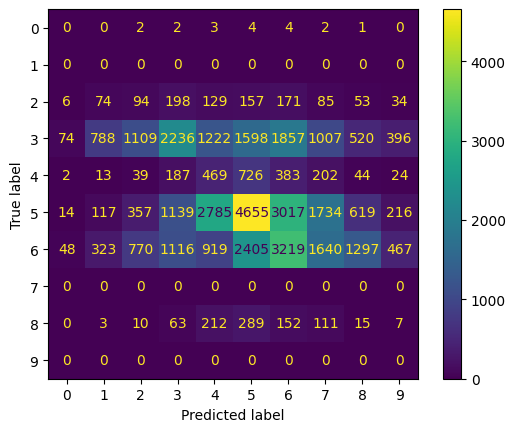

In [54]:
disp_train.plot()

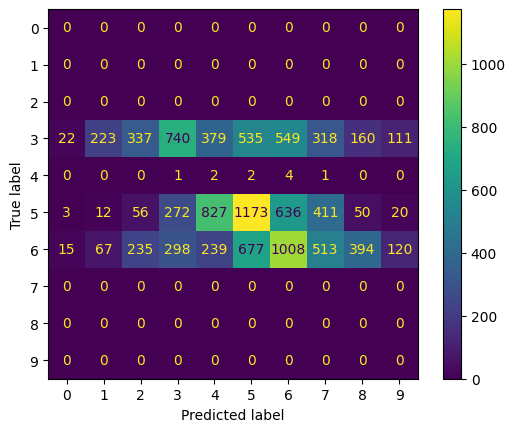

In [61]:
disp_test.plot()

In [62]:
from sklearn.metrics import classification_report

In [67]:
cr_train = classification_report(torch.tensor(train_pred,device='cpu'),torch.tensor(train_labels,device='cpu'))

<ipython-input-67-eb6f6710b126>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cr_train = classification_report(torch.tensor(train_pred,device='cpu'),torch.tensor(train_labels,device='cpu'))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn

In [66]:
print(cr_train)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00         0
           2       0.04      0.09      0.06      1001
           3       0.45      0.21      0.28     10807
           4       0.08      0.22      0.12      2089
           5       0.47      0.32      0.38     14653
           6       0.37      0.26      0.31     12204
           7       0.00      0.00      0.00         0
           8       0.01      0.02      0.01       862
           9       0.00      0.00      0.00         0

    accuracy                           0.26     41634
   macro avg       0.14      0.11      0.12     41634
weighted avg       0.40      0.26      0.30     41634



In [69]:
cr_test = classification_report(torch.tensor(test_pred,device='cpu'),torch.tensor(test_labels,device='cpu'))

<ipython-input-69-5c556826431c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cr_test = classification_report(torch.tensor(test_pred,device='cpu'),torch.tensor(test_labels,device='cpu'))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

In [70]:
print(cr_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.56      0.22      0.32      3374
           4       0.00      0.20      0.00        10
           5       0.49      0.34      0.40      3460
           6       0.46      0.28      0.35      3566
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.28     10410
   macro avg       0.15      0.10      0.11     10410
weighted avg       0.50      0.28      0.36     10410



In [ ]:
plt.plot(train_epoch_loss, label = 'Trainingsloss')
plt.plot(val_loss,label='Validierungsloss')
plt.xlabel('Epoche')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Loss pro Epoche')
plt.legend()
plt.show()

In [ ]:
plt.plot(torch.tensor(f1_acc,device='cpu'), label = 'Trainingsgenauigkeit')
plt.plot(torch.tensor(val_acc,device='cpu'),label='Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit pro Epoche')
plt.legend()
plt.show()

In [ ]:
model_pretrained = torch.load("/content/drive/MyDrive/Thesis/model.pt")

model.eval()

In [ ]:
loss,acc= test(net=model_pretrained,dataloader_test=dataloader_test,loss_fn=criterion)

In [ ]:
plt.plot(loss)
plt.xlabel('Loss pro Batch-Einheit')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Loss für die Testdaten')
plt.show()

In [ ]:
plt.plot(torch.tensor(acc,device='cpu'))
plt.xlabel('Genauigkeit pro Batch-Einheit')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit für die Testdaten')
plt.show()